# Traffic Anomalies Prediction over Network: Sparse + Low-rank model
(the whole project is public and can be downloaded at the following link: https://github.com/TomBombadil95/SPBD)

In [1]:
#importing libraries
import scipy.io
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
import seaborn as sns
from funct import *

The aim of this project is to analyze Internet Traffic flows in the Abilene network and in particular the detection of anomalies injected during the path.

Typically, when we observed the data in the backbone of an internet network, we can always split it in two components:
- the nominal traffic data, generated by user flows.
- the anomalous part, which are more interested to detect, such as hijacking activities, spams, etc.

The nominal component is tipycal low-rank, due to the topology of the network that induced correlation. While the second component is sparse along space and time, because not all the flows contains spams.

As we have seen during the lectures, the traffic flow data can be represented by a matrix M, formed as the sum of a low-rank matrix L and a sparse matrix S and to separate the two components, we could formulated the following costrained optimization problem (called __Principal Component Pursuit__):

$\min\limits_{\mathbf{L,S}} \left \| \mathbf{L} \right \|_{*} + \lambda \left \| \mathbf{S} \right \|_{1} \hspace{1cm} $ subject to  $  M = \mathbf{L + S} $ 
$\newline$ where $\lambda > 0$  is a regularization parameter


For this specific problem of traffic monitoring, I am going to use the Internet2 Abilene Network:
    
the data are based on measurements of origin-destination flows taken continuously over a seven-day period, starting December 22, 2003.  In particular, these data represent aggregate flow volumes for __12x24x7 = 2016__ consecutive 5 minute time intervals over the week, across __11x11 = 121__ origin-destination pairs (including self-loops) in the 11 node network (where nodes represent points-of-presence). 

They use the following four letter abbreviations:
_Atlanta (atla), Chicago (chin), Denver (dnvr), Houston (hstn), Indianapolis (ipls),
Kansas City (kscy), Los Angeles (losa), New York (nycm), Sunnyvale (snva), Seattle
(sttl) and Washington D.C. (wash)_

![alt text](NodesMap.png)

In [2]:
#loading data
data = scipy.io.loadmat('SAND_TM_Estimation_Data.mat')
full_R = data['A']; full_Q = data['X']; odn = data['odnames']; edge = data['edgenames']

#let's see the shape of the matrices
print('dim R: ',full_R.shape,'\ndim Q: ', full_Q.shape)

dim R:  (30, 121) 
dim Q:  (2016, 121)


`Q` represent the matrix of flow volumes, while `R` describes the routing of the 121 flows over the 30 edges between adjacent nodes.

`odn` is the character vector of origin-destination pair names, and `edge` is the vector of node pairs sharing an edge  

In [3]:
#here's all the edges of the map
edge

array([[array([' NYCM-CHIN'], dtype='<U10')],
       [array([' NYCM-WASH'], dtype='<U10')],
       [array([' CHIN-NYCM'], dtype='<U10')],
       [array([' CHIN-IPLS'], dtype='<U10')],
       [array([' WASH-NYCM'], dtype='<U10')],
       [array([' WASH-ATLA'], dtype='<U10')],
       [array([' ATLA-WASH'], dtype='<U10')],
       [array([' ATLA-IPLS'], dtype='<U10')],
       [array([' ATLA-HSTN'], dtype='<U10')],
       [array([' IPLS-CHIN'], dtype='<U10')],
       [array([' IPLS-ATLA'], dtype='<U10')],
       [array([' IPLS-KSCY'], dtype='<U10')],
       [array([' HSTN-ATLA'], dtype='<U10')],
       [array([' HSTN-KSCY'], dtype='<U10')],
       [array([' HSTN-LOSA'], dtype='<U10')],
       [array([' KSCY-IPLS'], dtype='<U10')],
       [array([' KSCY-HSTN'], dtype='<U10')],
       [array([' KSCY-DNVR'], dtype='<U10')],
       [array([' KSCY-SNVA'], dtype='<U10')],
       [array([' DNVR-KSCY'], dtype='<U10')],
       [array([' DNVR-SNVA'], dtype='<U10')],
       [array([' DNVR-STTL'], dtyp

In traffic data analysis the mechanism that allows flows from Origin-Destination (OD) is called _routing_: it consisted in operations that find a path between an OD in a network composed by several links and nodes (routers).

The goal of the analysis is to learn what are the flow of each user which are active in a certain time, but we __CANNOT__ measure all the flows!

Tipically we put some devices over the links that measures __Link Counts__, the summation of all packets that pass over a link in a certain amount of time:

$y_{l,t} = \sum_\limits{f \in \mathcal{F}} r_{l,f}(x_{f,t} + a_{f,t}) + v_{l,t}$ $\;\;\;\;\;\;$  with ${\scriptsize l = 1,..,L}$ and ${\scriptsize t = 1,.., T}$ 

where <br> $y(l,t)$ = #packets over link l at time t <br>
$x(f,t)$ = flow generated by user f at time t (part active flows)<br>
$a(f,t)$ = anomaly injected by user f at time t<br>
$r(l,f)$ = routing coefficient (=1 if flow f passes through link l)<br>
$v(l,t)$ = measurement noise

In matrix form (excluding the noise component):
$Y = R(X+A)$

So, in this case `Q` represent my ground-truth ($Y$). I have to generate the link counts through the routing matrix `R` and then estimate nominal and anomalous components ($X+A$), and finally comparing them with the ground-truth.

In [4]:
# Approximate link counts can be synthesized by defining Y = R*(X+A)'
Y =  full_R @ full_Q.T
print('Link counts matrix has shape: ', Y.shape)

Link counts matrix has shape:  (30, 2016)


Unfortunately, this is an underdetermined problem, because the total amount of links is much more smaller than the number of flows (and so, there are much more unknowns than observations): $L << F$ 

I can solve this problem by exploiting two facts:
- X is low-rank over space & time
- A is sparse over space & time

In order to tradeoff performance of the monitoring and costs I put traffic flow-level-meters that measures flow directly at the source! 

These devices are expensive, so I put them in strategical points for a few (f,t) pairs:

$z_{f,t} = x_{f,t} + a_{f,t} + w_{f,t}$

In matrix form:

$Z_\Pi = \mathcal{P}_\Pi (X + A) + W_\Pi $

$\mathcal{P}$ is the sampling operator on the set $\Pi$, that is a specific subset directly measured.

$W_\Pi$ is the noise measurements that , again, we are not going to considered.

With this method I add more observations.

In [5]:
#define max shape of flows F and time instants T 
T = full_Q.shape[0]; F = full_Q.shape[1]; 
N = F*T

#I want to sampling only the 10% of the dataset
perc = 0.1
m = round(N*perc)

print('Total flow volumes: N = FxT = ', N, '\nI am going to measure directly only', m, 'samples from the original dataset')

Total flow volumes: N = FxT =  243936 
I am going to measure directly only 24394 samples from the original dataset


In [6]:
#create a matrix of zeros and vectorize it
P = np.zeros([F,T]) 
P = P.flatten()

#taking randomly the index of samples
samp = np.random.randint(1 , N , size = m)

#flattenize the transpose of the groundtruth
Q  = full_Q.T.flatten()

#SAMPLING
P[samp] = 1
Z = cp.multiply(P, Q)

#reshaping the matrices to their original form 
Z0 = Z.value.reshape(F,T) ; Q = Q.reshape(F,T); P0 = P.reshape(F,T)
print('sampling matrix P = ', P0.shape, 
      '\noriginal traffic matrix Q = ', Q.shape, '\nflow-level-measures matrix Z = ', Z0.shape) 

sampling matrix P =  (121, 2016) 
original traffic matrix Q =  (121, 2016) 
flow-level-measures matrix Z =  (121, 2016)


Now, the last step, is to formulate the Optimization criterion, by minimize the observations error (or fitting error wrt link counts measurements) and the direct flow measurements error. Plus we encode the information about low-rankness and sparsity by enforcing them using penalties lambdas:

$(\hat{X}, \hat{A}) = arg \min\limits_{\mathbf{X,A}} \frac{1}{2} \left \| Y - R(X + A) \right \|^2_F
+\frac{1}{2} \left \|\mathcal{P}_\Pi (Z - X - A) \right \|^2_F + \lambda_*  \left \|X \right \|_* + \lambda_1  \left \|A \right \|_1
$

This is a convex problem, because the norm squared is convex and there are linear operations inside, it's a sum of two convex functions, and we have two proper norms with positive coefficients, hence the whole objective function is __convex__.

In particular, I am going to exploit the `CVXPY` package to solve this problem, by worked out it in another way.

In [9]:
#defining the variables
A = cp.Variable((F,T))
X = cp.Variable((F,T))
G = X+A

#defining the constraints
constraints = [Z0 == cp.multiply(P0,G),
             Y == R@G,
             A >= 0, X >= 0]

#defining the objective
lamb = 0.2
objective = cp.Minimize(cp.norm(X, 'nuc') + (lamb * cp.norm1(A)))

#solving the problem using Splitting Conic Solver (fastest method)
prob = cp.Problem(objective, constraints)
%time prob.solve(solver=cp.SCS)
print('status: ', prob.status)

Wall time: 2h 32min 34s
status:  optimal


In [7]:
#np.save('results/X_2016',X.value)
#np.save('results/A_2016',A.value)
#np.save('results/G_2016',G.value)

X = np.load('results/X_2016.npy')
A = np.load('results/A_2016.npy')
G = np.load('results/G_2016.npy')

In [8]:
#Let's calculate the Mean Squared Error

MSE_cp = cp.sum_squares(Q - G)/cp.sum_squares(Q)
print('MSE: ', MSE_cp.value)

MSE:  0.37411337280377116


It seems that CVX Optimization worked very well, the error is small enough, even if it took too much time to find the optimal solution.

Now I am going to show some plots to verify how much the recovered traffic is close to the true one.

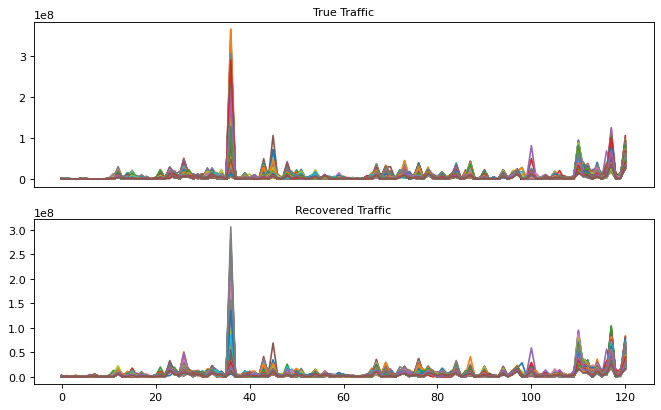

In [9]:
#Let's see and compare the true traffic and the recovered one
figure(figsize=(10, 6), dpi=80)
plt.subplot(2,1,1)
plt.plot(Q)
plt.title('True Traffic', fontsize = 10)
plt.gca().axes.get_xaxis().set_visible(False)
plt.subplot(2,1,2)
plt.plot(G)
plt.title('Recovered Traffic', fontsize = 10)
plt.show()

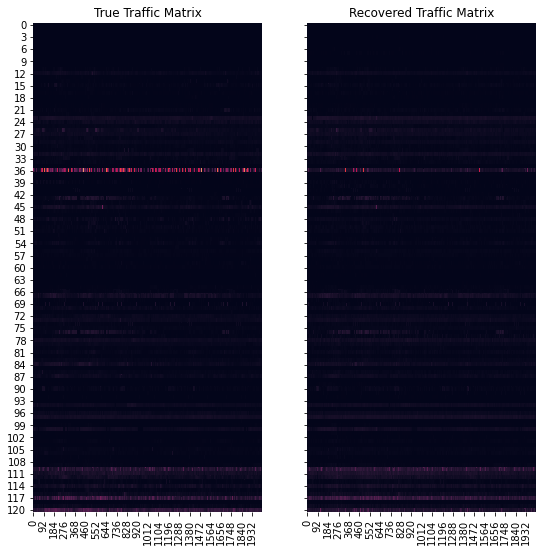

In [10]:
fig, ax =plt.subplots(1,2, sharey=True, figsize=(9,9))
sns.heatmap(Q, ax = ax[0], cbar = 0)
ax[0].set_title('True Traffic Matrix')
sns.heatmap(G, ax = ax[1], cbar = 0)
ax[1].set_title('Recovered Traffic Matrix')
plt.show()

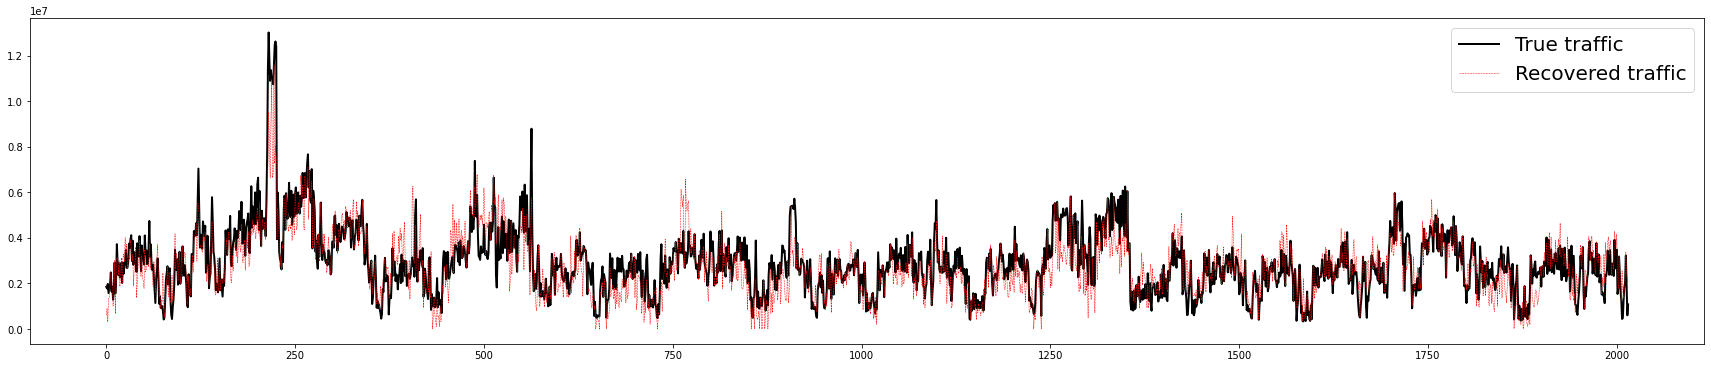

In [11]:
# DENVER - SUNNYVALE
figure(figsize=(30, 6))
plt.plot(Q[30, :], color = 'black', linewidth = 2, label = 'True traffic')
plt.plot(G[30, :],linestyle = '--', color = 'red',  linewidth = 0.5, label='Recovered traffic')
plt.legend(prop={"size":20})
plt.show()

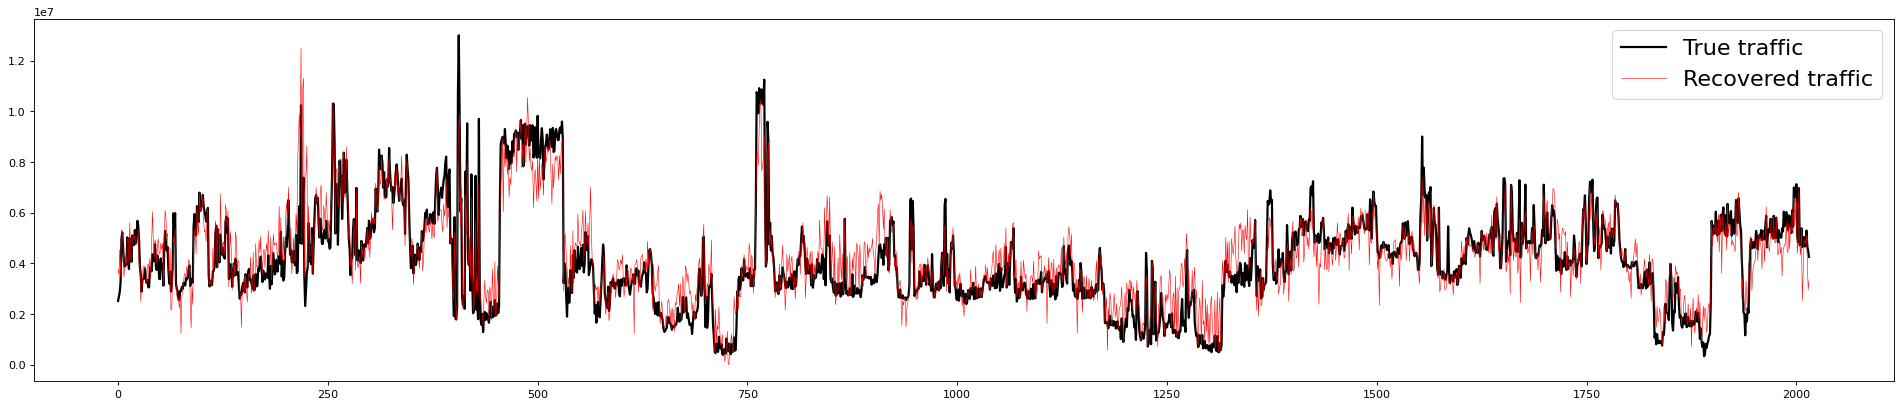

In [12]:
# DENVER - LOS ANGELES
figure(figsize=(30, 6), dpi=80)
plt.plot(Q[28, :], color = 'black', linewidth = 2, label = 'True traffic')
plt.plot(G[28, :], linestyle = '-' ,color = 'red',linewidth = 0.5, label = 'Recovered traffic')
plt.legend(prop={"size":20})
plt.show()

### Improve the optimization

To speed up and make a better optimization with `CVXPY`, that is a general purpose software, we need to decrease the observed slots in terms of time instants. 

The following code has a lower complexity and use the functions written in the `utils.py` file.

In [ ]:
'''
index = list(range(0,121,121//10)) #ignore the 121th flow
t = list(range(0, 2100, 100))  #ignore the last 16 time instants

L = []
S = []
M = []
for j in tqdm(range(10)):
    anomalies = []
    nominal = []
    tot = []
    for k in range(10):
        Q,R = set_data(full_Q,full_R, index[k], index[k+1], t[j], t[j+1] ,verb = not bool(tot))
        F,T,P,Q,Z,Y = preprocess(Q,R, verb = not bool(tot) and not bool(M))
        an,nom,gg = PCP(F,T,P,Q,Z,Y)
        anomalies.append(an)
        nominal.append(nom)
        tot.append(gg)

    an = np.vstack(anomalies)
    nom = np.vstack(nominal)
    gg = np.vstack(tot)
    
    L.append(nom)
    S.append(an)
    M.append(gg)

lowrank = np.hstack(L)
sparse = np.hstack(S)
recov = np.hstack(M)
'''

For the purpose of the project presentation, I have already save the overall results in a .npy file.

I can demonstrate the functioning of the code for a few slots, and show the overall results through some plots:

In [13]:
index = list(range(0,31, 31//10))
t = list(range(0, 101, 100//10))  

L = []
S = []
M = []
for j in tqdm(range(10)):
    anomalies = []
    nominal = []
    tot = []
    for k in range(10):
        Q,R = set_data(full_Q,full_R, index[k], index[k+1], t[j], t[j+1] ,verb = not bool(tot) and not bool(M))
        F,T,P,Q,R,Z,Y = preprocess(Q,R, verb = not bool(tot) and not bool(M))
        an,nom,gg = PCP(F,T,P,Q,R,Z,Y)
        anomalies.append(an)
        nominal.append(nom)
        tot.append(gg)

    an = np.vstack(anomalies)
    nom = np.vstack(nominal)
    gg = np.vstack(tot)
    
    L.append(nom)
    S.append(an)
    M.append(gg)

lowrank = np.hstack(L)
sparse = np.hstack(S)
recov = np.hstack(M)

  0%|                                                   | 0/10 [00:00<?, ?it/s]

dim R:  (30, 3) 
dim Q:  (10, 3)
Link counts matrix has shape:  (30, 10)
Total flow volumes: N = FxT =  3 x 10 = 30 
I am going to measure directly only 3 samples from the original dataset
sampling matrix P =  (3, 10) 
original traffic matrix Q =  (3, 10) 
flow-level-measures matrix Z =  (3, 10)
List Updated! Top minimum: 8.921e-01 , correspondent to lambda =  0.4111111111111111
List Updated! Top minimum: 1.800e-18 , correspondent to lambda =  0.1
List Updated! Top minimum: 3.863e-18 , correspondent to lambda =  0.1
List Updated! Top minimum: 4.456e-19 , correspondent to lambda =  0.5
List Updated! Top minimum: 8.521e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 2.238e-17 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.512e-19 , correspondent to lambda =  0.1
List Updated! Top minimum: 6.713e-21 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 2.472e-02 , correspondent to lambda =  0.5


 10%|████▎                                      | 1/10 [00:08<01:13,  8.15s/it]

List Updated! Top minimum: 2.887e-18 , correspondent to lambda =  0.1
List Updated! Top minimum: 7.506e-01 , correspondent to lambda =  0.4111111111111111
List Updated! Top minimum: 5.949e-21 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.043e-21 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.552e-20 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 8.556e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 1.679e-17 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 8.352e-20 , correspondent to lambda =  0.1
List Updated! Top minimum: 8.131e-21 , correspondent to lambda =  0.1


C:\Users\tommi\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


List Updated! Top minimum: 1.362e-01 , correspondent to lambda =  0.5


 20%|████████▌                                  | 2/10 [00:19<01:18,  9.76s/it]

List Updated! Top minimum: 2.853e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 1.062e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 5.928e-19 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.290e-22 , correspondent to lambda =  0.1
List Updated! Top minimum: 2.049e-18 , correspondent to lambda =  0.1
List Updated! Top minimum: 9.934e-01 , correspondent to lambda =  0.32222222222222224
List Updated! Top minimum: 3.459e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 2.257e-17 , correspondent to lambda =  0.1
List Updated! Top minimum: 4.542e-20 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 4.048e-01 , correspondent to lambda =  0.5


 30%|████████████▉                              | 3/10 [00:28<01:07,  9.68s/it]

List Updated! Top minimum: 1.855e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 4.824e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 1.217e-16 , correspondent to lambda =  0.1
List Updated! Top minimum: 6.334e-22 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.024e-21 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 8.563e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 2.280e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 6.264e-19 , correspondent to lambda =  0.1
List Updated! Top minimum: 7.522e-19 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 1.095e-01 , correspondent to lambda =  0.5


 40%|█████████████████▏                         | 4/10 [00:35<00:50,  8.43s/it]

List Updated! Top minimum: 9.708e-18 , correspondent to lambda =  0.5
List Updated! Top minimum: 6.693e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 3.374e-19 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 1.272e-20 , correspondent to lambda =  0.1
List Updated! Top minimum: 3.358e-17 , correspondent to lambda =  0.1
List Updated! Top minimum: 9.911e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 6.679e-18 , correspondent to lambda =  0.1
List Updated! Top minimum: 3.608e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 4.467e-19 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 2.699e-01 , correspondent to lambda =  0.4555555555555556


 50%|█████████████████████▌                     | 5/10 [00:41<00:38,  7.65s/it]

List Updated! Top minimum: 3.838e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 8.593e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 1.074e-18 , correspondent to lambda =  0.5
List Updated! Top minimum: 9.599e-21 , correspondent to lambda =  0.1
List Updated! Top minimum: 2.174e-17 , correspondent to lambda =  0.1
List Updated! Top minimum: 8.591e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 1.823e-17 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.351e-19 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 1.264e-19 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.392e-01 , correspondent to lambda =  0.5


 60%|█████████████████████████▊                 | 6/10 [00:47<00:28,  7.19s/it]

List Updated! Top minimum: 2.435e-20 , correspondent to lambda =  0.1
List Updated! Top minimum: 7.067e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 1.087e-16 , correspondent to lambda =  0.5
List Updated! Top minimum: 4.125e-22 , correspondent to lambda =  0.1
List Updated! Top minimum: 4.508e-18 , correspondent to lambda =  0.23333333333333334
List Updated! Top minimum: 8.518e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 7.549e-17 , correspondent to lambda =  0.5
List Updated! Top minimum: 7.425e-19 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 3.161e-19 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 1.747e-01 , correspondent to lambda =  0.5


 70%|██████████████████████████████             | 7/10 [00:55<00:22,  7.34s/it]

List Updated! Top minimum: 6.792e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 8.527e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 6.764e-19 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.972e-21 , correspondent to lambda =  0.1
List Updated! Top minimum: 4.790e-18 , correspondent to lambda =  0.18888888888888888
List Updated! Top minimum: 9.884e-01 , correspondent to lambda =  0.3666666666666667
List Updated! Top minimum: 9.838e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 1.211e-18 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.510e-21 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 7.199e-02 , correspondent to lambda =  0.5


 80%|██████████████████████████████████▍        | 8/10 [01:04<00:15,  7.97s/it]

List Updated! Top minimum: 4.223e-17 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 9.606e-01 , correspondent to lambda =  0.23333333333333334
List Updated! Top minimum: 1.017e-17 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 6.351e-22 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 1.286e-21 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 9.939e-01 , correspondent to lambda =  0.32222222222222224
List Updated! Top minimum: 6.764e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 2.048e-19 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 1.176e-19 , correspondent to lambda =  0.1
List Updated! Top minimum: 1.146e-02 , correspondent to lambda =  0.5


 90%|██████████████████████████████████████▋    | 9/10 [01:11<00:07,  7.68s/it]

List Updated! Top minimum: 1.207e-17 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 9.575e-01 , correspondent to lambda =  0.3666666666666667
List Updated! Top minimum: 5.298e-19 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 6.376e-21 , correspondent to lambda =  0.1
List Updated! Top minimum: 5.508e-19 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 8.450e-01 , correspondent to lambda =  0.5
List Updated! Top minimum: 4.507e-18 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 4.455e-20 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 5.369e-21 , correspondent to lambda =  0.14444444444444446
List Updated! Top minimum: 1.066e-02 , correspondent to lambda =  0.5


100%|██████████████████████████████████████████| 10/10 [01:17<00:00,  7.80s/it]

List Updated! Top minimum: 5.747e-20 , correspondent to lambda =  0.14444444444444446


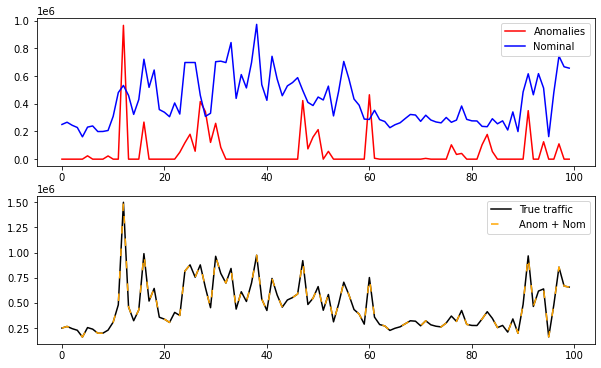

In [14]:
args = [sparse, lowrank, full_Q.T, recov]

show_plots(args, 14)

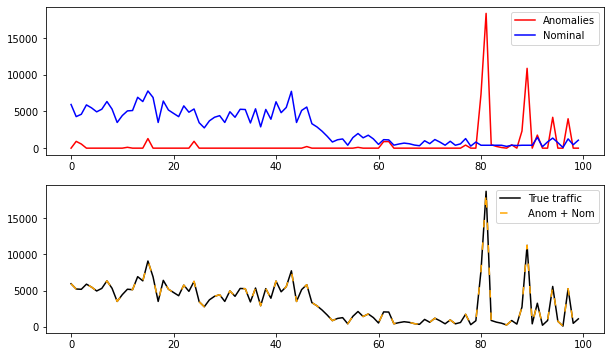

In [15]:
show_plots(args, 2)

In [16]:
print('Partial MSE: ', 
      (cp.sum_squares(full_Q.T[:recov.shape[0],:100] - (recov))/cp.sum_squares(full_Q.T[:recov.shape[0],:100])).value)

Partial MSE:  0.14405813981690968


In [17]:
#let's see the overall results
overall_anomalies = np.load('results/sparse_component.npy')
overall_nominal = np.load('results/low_rank_component.npy')

print('Overall MSE: ', 
      (cp.sum_squares(full_Q.T[:120,:] - (overall_anomalies + overall_nominal))/cp.sum_squares(full_Q.T[:120,:])).value)

Overall MSE:  0.4945920470903456


In [18]:
args2 = [overall_anomalies, overall_nominal, full_Q.T, overall_anomalies+overall_nominal]

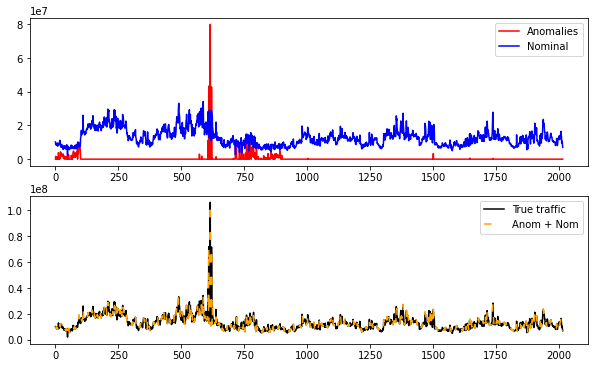

In [19]:
show_plots(args2, i = np.random.randint(1 , 119),t1 = 2016)

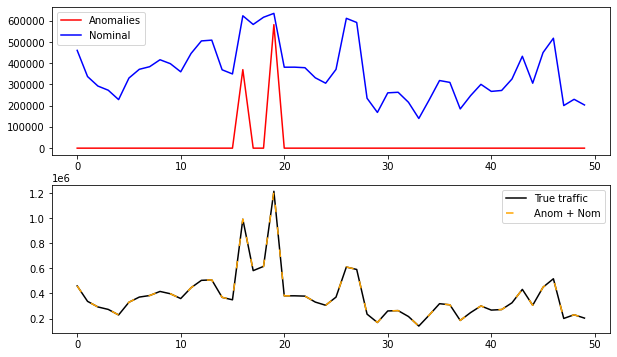

In [20]:
show_plots(args2, i = 64 ,t0 = 0, t1 = 50)

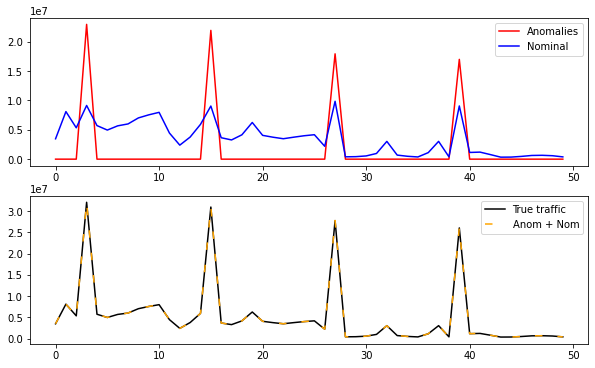

In [21]:
show_plots(args2, i = 69,t1 = 50)

### Robust Component Analysis without CVXPY

As last tentative to increase accuracy and speed, I put aside the CVX tool, and by taking full advantage of the theory I will try to apply the _Alternating Direction Method of Multipliers_ (ADMM) to implement a Robust Component Analysis directly on the Ground-Truth matrix.

The idea behind this method is a proximal gradient algorithm with lower complexity which can solve the problem by alternating the optimization between low-rank component and sparse component.

In order to do this, I need to add some new functions to my code:

In [22]:
#first of all, we need to define PROXIMAL OPERATORS (that are known for l1 and nuclear norm).

def frob_norm(X):
    return np.linalg.norm(X, ord='fro')
def prox_l1_norm(X, lmb):
        return np.sign(X) * np.maximum((np.abs(X) - lmb), np.zeros(X.shape))
def prox_nuc_norm(X, lmb):
        U, S, V = np.linalg.svd(X, full_matrices=False)
        return np.dot(U, np.dot(np.diag(prox_l1_norm(S, lmb)), V))

To write down this code I took hints and ispiration from https://arxiv.org/pdf/0912.3599.pdf *(algorithm: page 29)*:

1.  $ S_0 = Y_0 = 0 \ ;\  \mu > 0 $ 

2. $\textbf{While} \ not\  converged\  \textbf{do}$ 

3. $L_{k+1} = D_\mu ( M - S_k - \frac{1}{\mu}Y_k)$

4. $S_{k+1} = S_{\lambda\mu}(M - L_{k+1} - \frac{1}{\mu}Y_k)$ 

5. $Y_{k+1} = Y_k + \mu(M - L_{k+1} - S_{k+1}) $

6. $\textbf{ End  while}$ 

7. $ \textbf{Output} :  L,S$

In [54]:
def ADMM(Q):
        A = U = X = np.zeros(Q.shape)
        lam = 1/np.sqrt(np.max(Q.shape))
        u = np.prod(Q.shape)/(4*np.linalg.norm(Q, ord=1))

        tol = 1E-7*frob_norm(Q)
        err = np.Inf; iter = 0
        
        while (err > tol) and iter < 1000:
            X = prox_nuc_norm(Q - A + (1/u)*U, 1/u)                           
            A = np.maximum(prox_l1_norm(Q - X + (1/u * U), 1/u * lam), np.zeros(Q.shape))             
            U = U + u*(Q - X - A)                                 
            err = frob_norm(Z0 - np.multiply(P0,X.T) - np.multiply(P0,A.T))
            iter += 1
            if (iter % 100) == 0 or iter == 1 or iter > 1000 or err <= tol:
                print('iteration: {0}, Converging...'.format(iter))
        return X, A

In [55]:
X,A = ADMM(full_Q)

iteration: 1, Converging...
iteration: 100, Converging...
iteration: 200, Converging...
iteration: 300, Converging...
iteration: 400, Converging...
iteration: 500, Converging...
iteration: 600, Converging...
iteration: 700, Converging...
iteration: 800, Converging...
iteration: 900, Converging...
iteration: 1000, Converging...


In [57]:
MSE_cp = cp.sum_squares(full_Q - (X+A))/cp.sum_squares(full_Q)
print('MSE_rpca: ', MSE_cp.value)

MSE_rpca:  1.177359688990948e-13


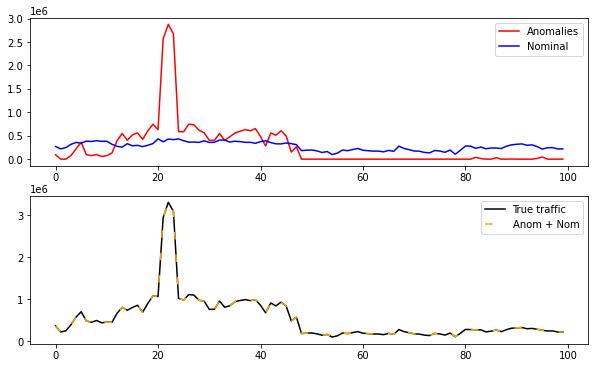

In [69]:
args3 = [A.T, X.T, full_Q.T, (A+X).T]
show_plots(args3, i = 1,t1 = 100)

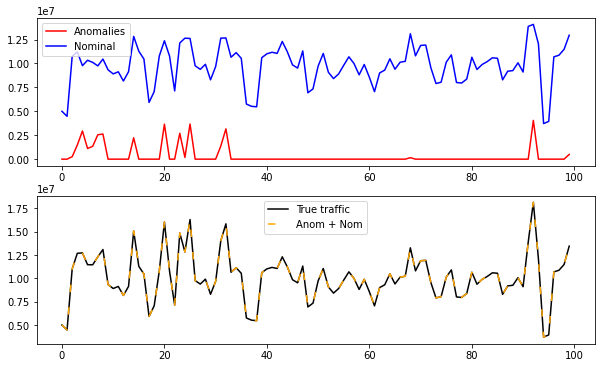

In [70]:
show_plots(args3, i = 112,t1 = 100)

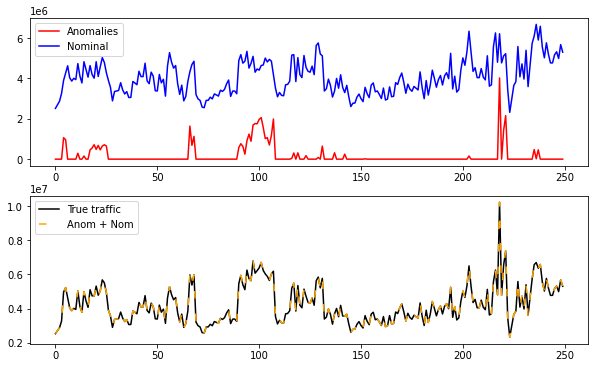

In [72]:
show_plots(args3, i = 28,t1 = 250)

### References
- Structural analysis of network traffic flows (2004, A. Lakhina, K. Papgiannaki, C. Crovella, M. Diot, E. Kolaczyk,
	and N. Taft)
- Vessel Traffic flow separation-Prediction using low-rank and sparse decomposition (Oct 2017, Ryan Wen Liu, Jinwei Chen et al.)
- Robust Principal Component Analysis (Dec 2009, Candes E., Xiaodong L. and Wright J.)
- Slides for Signal Processing for Big Data - Mathematical Optimization: Theory and Applications to DS (Sergio Barbarossa and Paolo Di Lorenzo)